In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates


In [2]:
from scipy.integrate import dblquad
def beamFraction(x_=0, y_=0, dx=1, dy=1,beam_x = 0, beam_y=0, beam_sigmaX=10, beam_sigmaY=10, r=None):
    amplitude, xo, yo, sigma_x, sigma_y, theta, offset = 1/628.3185307179515, beam_x, beam_y, beam_sigmaX, beam_sigmaY, 0, 0

    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    f = lambda y,x: offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)+ c*((y-yo)**2)))

    if r is None:
        return dblquad(f, x_-dx/2, x_+dx/2, y_-dy/2, y_+dy/2)[0]
    else:
        return dblquad(f, x_-r, x_+r, lambda x: y_-(r**2-(x-x_)**2)**.5, lambda x: y_+(r**2-(x-x_)**2)**.5)[0]


In [3]:
dfPosition=pd.read_csv('logs/Positioning.csv')
dfPosition.Time=pd.to_datetime(dfPosition.Time)
dfPosition.set_index('Time',inplace=True)
dfPosition.columns=['Distance','MotionTable']
dfPosition.drop('MotionTable',axis=1,inplace=True)

In [4]:
#foil position in distance to ECON
foilRadius=5.8674/2 #mm
FoilPositions={'0':(-20,0),  ## 20 mm closer to beam in x, same location in y
               '1':(0,0),    ## same location as econ
               '2':(0,20),
               '3':(0,-20)}

In [5]:
dfPosition['ECON_BeamFraction'] = np.vectorize(beamFraction)(dfPosition.Distance,0,5.19,5.19)
for i,xy in FoilPositions.items():
    dfPosition[f'Foil_{i}_BeamFraction'] = np.vectorize(beamFraction)(dfPosition.Distance+xy[0],xy[1],r=foilRadius)


In [6]:
dfBeam=pd.read_csv('logs/BeamInfoSummedToSpills.csv')
dfBeam.timestamp=pd.to_datetime(dfBeam.timestamp)
dfBeam.set_index('timestamp',inplace=True)


In [7]:
#merge two dataframces
df=dfPosition.merge(dfBeam,left_index=True,right_index=True,how='outer')
#forward fill RelPosition
df.Distance=df.Distance.ffill()
df.ECON_BeamFraction=df.ECON_BeamFraction.ffill()
df.Foil_0_BeamFraction=df.Foil_0_BeamFraction.ffill()
df.Foil_1_BeamFraction=df.Foil_1_BeamFraction.ffill()
df.Foil_2_BeamFraction=df.Foil_2_BeamFraction.ffill()
df.Foil_3_BeamFraction=df.Foil_3_BeamFraction.ffill()
#drop all entries without a proton Count
df.dropna(inplace=True)

In [8]:
for c in ['ECON_BeamFraction','Foil_0_BeamFraction','Foil_1_BeamFraction','Foil_2_BeamFraction','Foil_3_BeamFraction']:
    df[c.replace('BeamFraction','Protons')]=df[c]*df.protonCount

In [9]:
df['ECON_IntegratedProtons']=df.ECON_Protons.cumsum()

In [10]:
foilMeasureTime = pd.to_datetime('2022-03-21 09:00:00')
na24HalfLife=np.timedelta64(int(14.9590*60*60),'s')
na22HalfLife=np.timedelta64(int(2.6019*365*24*60*60),'s')
be7HalfLife=np.timedelta64(int(53.22*24*60*60),'s')

(foilMeasureTime-df.index).values/be7HalfLife
(foilMeasureTime-df.index).values/na24HalfLife
(foilMeasureTime-df.index).values/na22HalfLife


array([0.01018546, 0.01018473, 0.010184  , ..., 0.00385807, 0.00385732,
       0.00385659])

In [11]:
MeanBeamTime=foilMeasureTime-np.timedelta64(int(((foilMeasureTime-df.index).astype(int)*df.protonCount).sum()/df.protonCount.sum()),'ns')
MeanBeamTime_ECON=foilMeasureTime-np.timedelta64(int(((foilMeasureTime-df.index).astype(int)*df.ECON_Protons).sum()/df.ECON_Protons.sum()),'ns')
MidBeamTime_ECON=(abs(df.ECON_IntegratedProtons - (df.ECON_IntegratedProtons[-1]/2))).idxmin()

In [12]:
MeanBeamTime

Timestamp('2022-03-13 19:09:55.139312158')

In [13]:
MeanBeamTime_ECON

Timestamp('2022-03-16 02:25:26.062160388')

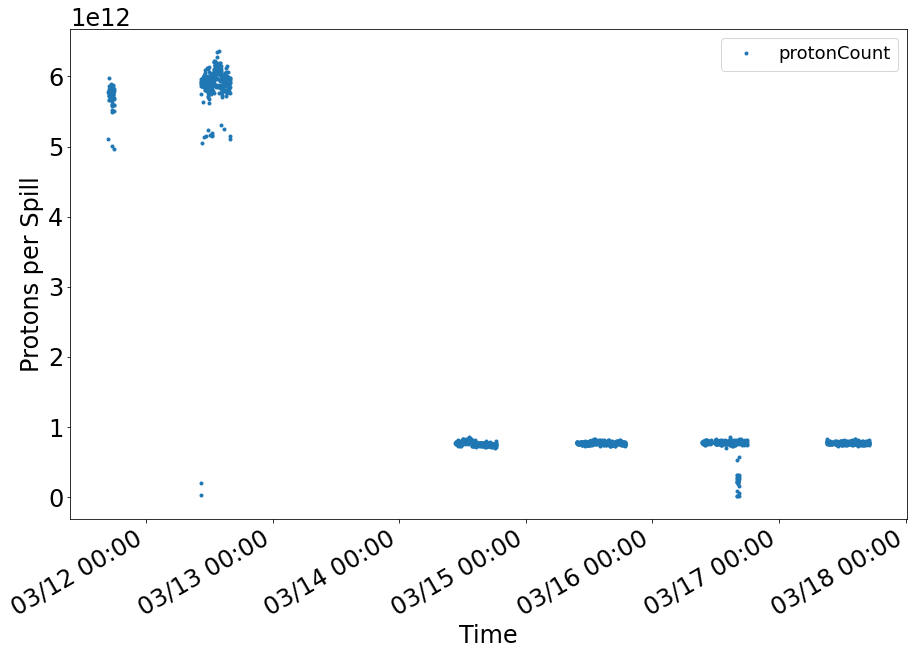

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
df.plot(y='protonCount',style=".",ax=ax)
ax.set_ylabel('Protons per Spill',fontsize=24)
ax.set_xlabel('Time',fontsize=24)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.yaxis.get_offset_text().set_size(24)
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d %H:%M'))
ax.legend(fontsize=18)
# ax.set_xlim('12-15-2021 06:00','12-17-2021 18:00')


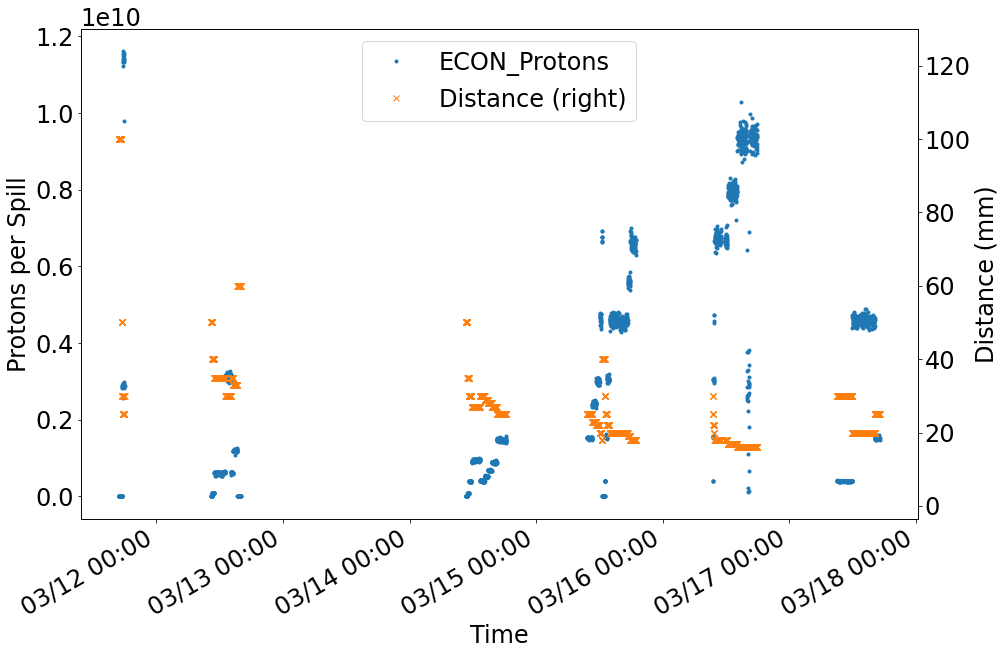

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
df.plot(y='ECON_Protons',ax=ax,style=".")
df.plot(y='Distance',ax=ax,secondary_y=True,style='x')
ax.set_ylabel('Protons per Spill',fontsize=24)
ax.right_ax.set_ylabel('Distance (mm)',fontsize=24)
ax.set_xlabel('Time',fontsize=24)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.right_ax.tick_params(axis='y',labelsize=24)
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d %H:%M'))
ax.yaxis.get_offset_text().set_size(24)
ax.right_ax.yaxis.get_offset_text().set_size(24)
ax.right_ax.set_ylim(-3.5,130)

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax.right_ax.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=24)


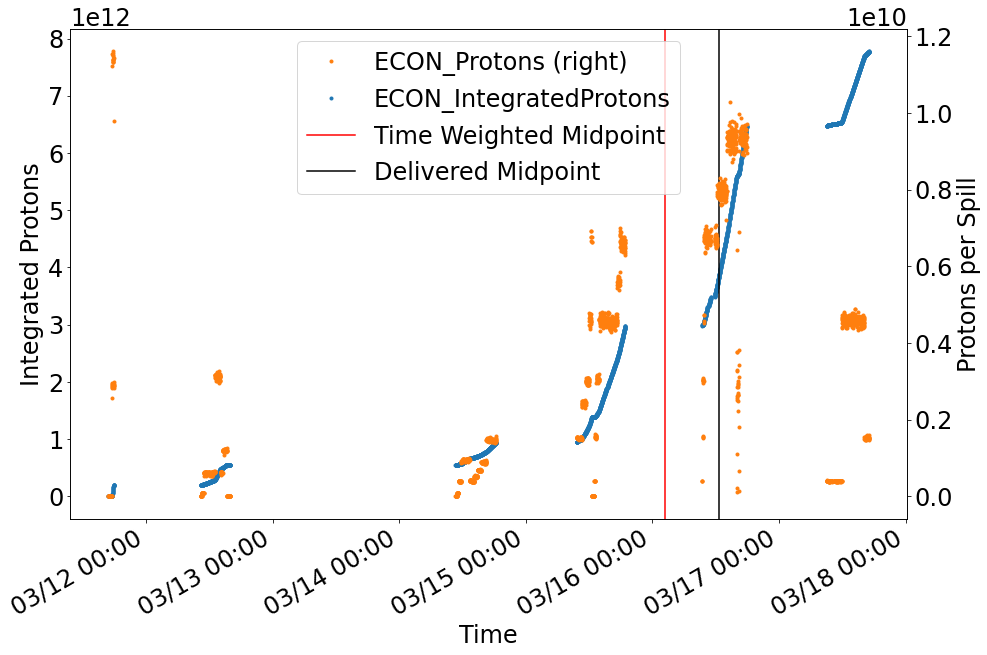

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
df.plot(y='ECON_IntegratedProtons',ax=ax,style=".")
df.plot(y='ECON_Protons',ax=ax,style=".",secondary_y=True)
ax.set_ylabel('Integrated Protons',fontsize=24)
ax.right_ax.set_ylabel('Protons per Spill',fontsize=24)

ax.set_xlabel('Time',fontsize=24)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)
ax.right_ax.tick_params(axis='y',labelsize=24)
ax.xaxis.set_major_formatter(dates.DateFormatter('%m/%d %H:%M'))
ax.yaxis.get_offset_text().set_size(24)
ax.right_ax.yaxis.get_offset_text().set_size(24)
ax.axvline(x=MeanBeamTime_ECON,c='r',label='Time Weighted Midpoint')
ax.axvline(x=MidBeamTime_ECON,c='k',label='Delivered Midpoint')
lines_2, labels_2 = ax.get_legend_handles_labels()
lines_1, labels_1 = ax.right_ax.get_legend_handles_labels()

ax.legend(lines_1 + lines_2, labels_1 + labels_2, fontsize=24,loc='upper center')
# ax.set_xlim('12-15-2021 06:00','12-17-2021 18:00')
